In [7]:
# ==============================================================================
# PRÁTICA 01 - NLP: CLASSIFICAÇÃO DE FAKE NEWS
# RU: 4061848
# ==============================================================================

# --- 0. INSTALAÇÃO E IMPORTAÇÃO DAS BIBLIOTECAS ---
# Comandos para baixar os arquivos necessários para o Google Colab.
# AVISO: O erro "mv: cannot move './NLP/data' to './data': Directory not empty"
# pode ser ignorado, pois ocorre ao tentar mover arquivos que já existem e
# não afeta o funcionamento do código.

In [8]:
!wget https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv -O pre-processed.csv
!git clone https://github.com/N-CPUninter/NLP.git
!rm ./NLP/*.ipynb
!mv ./NLP/* .
!rm -r NLP

import pandas as pd
import nltk
import re
import string
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from funcoes_auxiliares import gerar_nuvem_palavras


--2025-08-12 02:02:56--  https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20434897 (19M) [text/plain]
Saving to: ‘pre-processed.csv’

pre-processed.csv   100%[===================>]  19.49M   125MB/s    in 0.2s    

2025-08-12 02:02:56 (125 MB/s) - ‘pre-processed.csv’ saved [20434897/20434897]

Cloning into 'NLP'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 34 (delta 9), reused 25 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 1.27 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (9/9), done.
mv: cannot move './NLP/data' to './data': Directory 

In [9]:
# Download dos recursos NLTK essenciais
# Removida a linha 'nltk.download('punkt_tab')' pois ela causa um erro de recurso não encontrado.
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('rslp', quiet=True)

True

In [10]:
# --- 1. AQUISIÇÃO E ESTRUTURAÇÃO DOS DADOS ---
print("Passo 1: Carregando e estruturando os dados...")
url = "https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv"
df = pd.read_csv(url)
df.dropna(subset=['preprocessed_news', 'label'], inplace=True)
print("Dados carregados com sucesso.")

Passo 1: Carregando e estruturando os dados...
Dados carregados com sucesso.


In [11]:
# --- 2. PRÉ-PROCESSAMENTO DOS TEXTOS ---
print("\nPasso 2: Iniciando o pré-processamento dos textos...")



Passo 2: Iniciando o pré-processamento dos textos...


In [12]:
# Inicializa as ferramentas do NLTK
import nltk
nltk.download('punkt_tab')
stop_words = set(stopwords.words('portuguese'))
stemmer = RSLPStemmer()

def limpar_texto(texto):
    """
    Função para realizar a limpeza completa do texto conforme o roteiro.
    """
    if not isinstance(texto, str):
      return []

    # 1.1. Tokenizar, 1.3. Deixar tudo em minúsculas
    tokens = nltk.word_tokenize(texto.lower(), language='portuguese')

    palavras_limpas = []
    for palavra in tokens:
        # 1.2. Retirar acentos, números e caracteres especiais
        palavra = re.sub(r'[^a-z]', '', palavra)

        # 1.4. Retirar stopwords, pontuações e palavras curtas
        if palavra and palavra not in stop_words and len(palavra) > 2:
            # 1.5. Deixar palavras apenas com radical (STEM)
            palavra_stemmed = stemmer.stem(palavra)
            palavras_limpas.append(palavra_stemmed)

    return palavras_limpas

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
# Aplica a função de limpeza e cria uma nova coluna com os tokens
df['tokens_limpos'] = df['preprocessed_news'].apply(limpar_texto)
df.dropna(subset=['tokens_limpos'], inplace=True) # Remove linhas onde o pré-processamento resultou em nulo

In [14]:
# 1.6. Realizar truncamento para normalizar a quantidade de palavras
df_fake = df[df['label'] == 'fake']
media_palavras_fake = int(df_fake['tokens_limpos'].apply(len).mean())

print(f"Normalizando todos os textos para o tamanho médio dos textos FAKE: {media_palavras_fake} palavras.")

df['tokens_truncados'] = df['tokens_limpos'].apply(lambda x: x[:media_palavras_fake])

Normalizando todos os textos para o tamanho médio dos textos FAKE: 104 palavras.


In [15]:
# 1.7. Remontar as notícias em string para a vetorização
df['texto_final'] = df['tokens_truncados'].apply(lambda x: ' '.join(x))
print("Pré-processamento concluído.")

Pré-processamento concluído.


In [16]:
# --- 3. MINERAÇÃO E MODELAGEM ---
print("\nPasso 3: Vetorizando os dados e treinando o modelo...")
# Mapear rótulos para valores numéricos (FAKE=1, REAL=0)
df['label_numeric'] = df['label'].map({'fake': 1, 'true': 0})

# Definir X (features) e y (target)
X = df['texto_final']
y = df['label_numeric']


Passo 3: Vetorizando os dados e treinando o modelo...


In [17]:
# 2. Criar matriz de frequências TF-IDF com ngramas de 1 a 3 palavras
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=15000, min_df=3, max_df=0.8)
X_tfidf = vectorizer.fit_transform(X)

In [18]:
# 3. Dividir o corpus em 75% para treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.25, random_state=42, stratify=y
)

In [19]:
# 4. Fazer regressão logística com solver = 'lbfgs'
modelo = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [20]:
# 5. Realizar predição e 6. Calcular a acurácia
y_pred = modelo.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)
print(f"Modelo treinado. Acurácia final: {acuracia:.2%}")

Modelo treinado. Acurácia final: 89.61%


In [21]:
# --- 4. REPRESENTAÇÃO (NUVENS DE PALAVRAS) E RESPOSTAS ---

# Obter os nomes dos termos (palavras, bigramas, trigramas)
features = vectorizer.get_feature_names_out()
# Obter os pesos (coeficientes) que o modelo aprendeu para cada termo
pesos = modelo.coef_[0]


--- QUESTÃO 01: ANÁLISE DOS TEXTOS VERDADEIROS ---
RU: 4061848
Acurácia do modelo: 89.61%
Quantidade de palavras, bigramas e trigramas usados para identificar textos VERDADEIROS: 8528
Gerando Nuvem de Palavras para textos VERDADEIROS...
   * Um total de 8528 tokens foram computadas a partir do conjunto de dados.



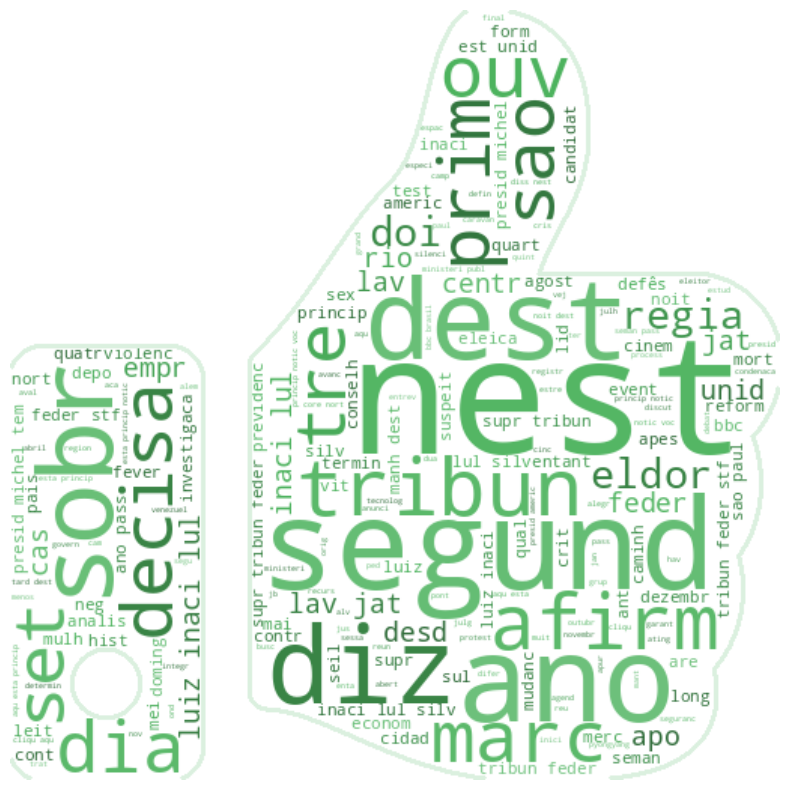

(<wordcloud.wordcloud.WordCloud at 0x7d67413ff050>, 8528)

In [22]:
# ==============================================================================
# QUESTÃO 01: ANÁLISE DOS TEXTOS VERDADEIROS (REAL)
# ==============================================================================
print("\n--- QUESTÃO 01: ANÁLISE DOS TEXTOS VERDADEIROS ---")

# Dicionário com termos e pesos para a classe REAL (coeficiente < 0)
pesos_real = {features[i]: abs(pesos[i]) for i in range(len(pesos)) if pesos[i] < 0}

print(f"RU: 4061848")
print(f"Acurácia do modelo: {acuracia:.2%}")
print(f"Quantidade de palavras, bigramas e trigramas usados para identificar textos VERDADEIROS: {len(pesos_real)}")

print("Gerando Nuvem de Palavras para textos VERDADEIROS...")
gerar_nuvem_palavras(
    dicionario_tokens_e_frequencia=pesos_real,
    arquivo_mascara='thumbs_up_mask.png'
)


--- QUESTÃO 02: ANÁLISE DOS TEXTOS FALSOS ---
RU: 4061848
Quantidade de palavras, bigramas e trigramas usados para identificar textos FALSOS: 6472
Técnicas de pré-processamento usadas: Tokenização, conversão para minúsculas, remoção de acentos, números, pontuações e stopwords, stemming (radicalização) e truncamento para normalização de tamanho.
Tipo de modelo escolhido: Regressão Logística (LogisticRegression).
Gerando Nuvem de Palavras para textos FALSOS...
   * Um total de 6472 tokens foram computadas a partir do conjunto de dados.



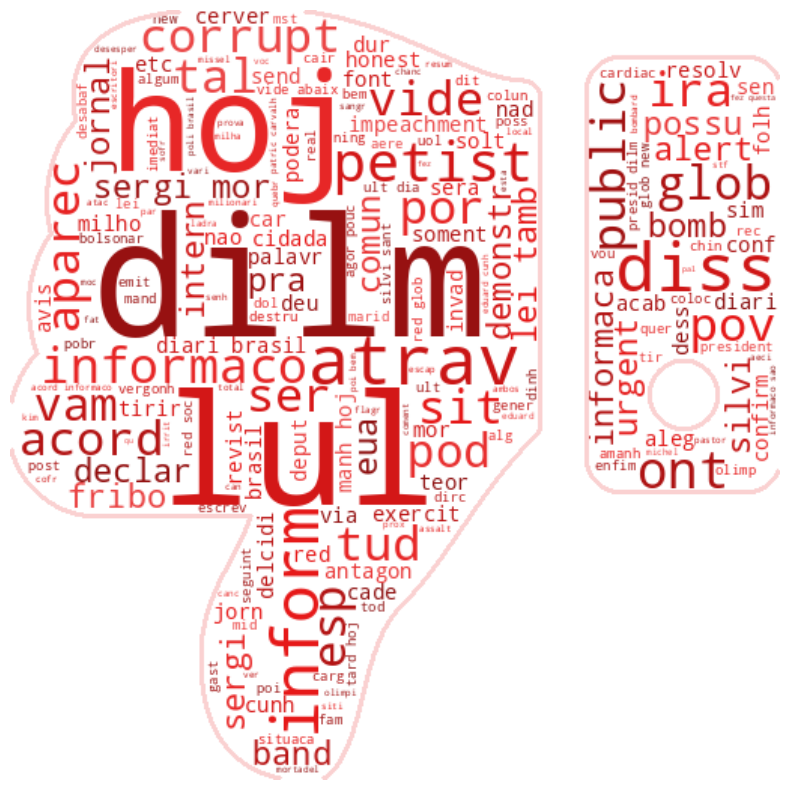

(<wordcloud.wordcloud.WordCloud at 0x7d673d202250>, 6472)

In [23]:

# ==============================================================================
# QUESTÃO 02: ANÁLISE DOS TEXTOS FALSOS (FAKE)
# ==============================================================================
print("\n--- QUESTÃO 02: ANÁLISE DOS TEXTOS FALSOS ---")

# Dicionário com termos e pesos para a classe FAKE (coeficiente > 0)
pesos_fake = {features[i]: pesos[i] for i in range(len(pesos)) if pesos[i] > 0}

print(f"RU: 4061848")
print(f"Quantidade de palavras, bigramas e trigramas usados para identificar textos FALSOS: {len(pesos_fake)}")
print("Técnicas de pré-processamento usadas: Tokenização, conversão para minúsculas, remoção de acentos, números, pontuações e stopwords, stemming (radicalização) e truncamento para normalização de tamanho.")
print("Tipo de modelo escolhido: Regressão Logística (LogisticRegression).")

print("Gerando Nuvem de Palavras para textos FALSOS...")
gerar_nuvem_palavras(
    dicionario_tokens_e_frequencia=pesos_fake,
    arquivo_mascara='thumbs_down_mask.png'
)